# Receptive fields
For each voxel, the a set of features with the values from the surrounding voxels are created and classified


In [5]:
import sys
path_bnd = '../'
sys.path.insert(1, path_bnd)
import analysis_tools.data_loader as dl
from visual_tools.visual import display
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from pgtda.images import RollingSubImageTransformer, make_image_union

## Import data 

In [6]:
data_dir = '/Users/julian/stroke_research/brain_and_donuts/full_datasets'
clinical_inputs, ct_inputs, ct_lesion_GT, mri_inputs, mri_lesion_GT, brain_masks, ids, params = \
dl.load_structured_data(data_dir, 'withAngio_all_2016_2017.npz')

# Reshape ct_inputs as it has 1 channel
ct_inputs = ct_inputs.reshape((*ct_inputs.shape[:-1]))

Loading a total of 113 subjects.
Sequences used: {'ct_sequences': ['wbetted_Angio'], 'ct_label_sequences': ['wcoreg_VOI'], 'mri_sequences': [], 'mri_label_sequences': []}
0 subjects had been excluded.


## Setting up data exploration set

In [7]:
# Data subset
n_images = 1
X = (ct_inputs[:n_images] * brain_masks[:n_images])[range(n_images), ::2, ::2, ::2]
y = (ct_lesion_GT[:n_images] * brain_masks[:n_images])[range(n_images), ::2, ::2, ::2]

print(X.shape)
print(y.shape)

(1, 40, 48, 40)
(1, 40, 48, 40)


Image center:  19 23 19
Image center value:  -0.0
Image center:  19 23 19
Image center value:  0.0


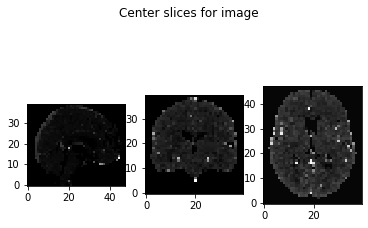

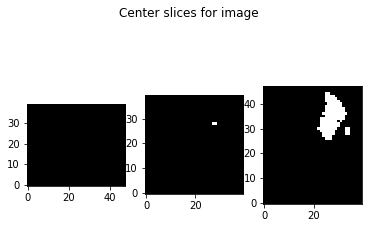

<module 'matplotlib.pyplot' from '/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [8]:
display(X[0])
display(y[0])

## Feature Creation
For each voxel, the features correspond to the values in its receptive field

In [15]:
transformer = RollingSubImageTransformer(width=[5,5,5], padding='same')
X_features = transformer.fit_transform(X)
print(X_features.shape)

/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/pgtda/images/pipeline.py:495: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



(1, 40, 48, 40, 5, 5, 5)


Image center:  2 2 2
Image center value:  0.0


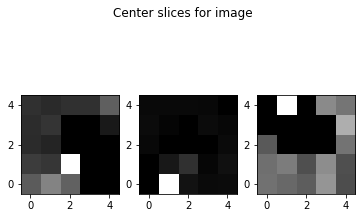

<module 'matplotlib.pyplot' from '/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [18]:
display(X_features[0, 20, 20, 20])

In [29]:
n_i, n_x, n_y, n_z = X_features.shape[0:4]
X_features = X_features.reshape(n_i, n_x, n_y, n_z, -1)
n_features = X_features.shape[-1]
print(X_features.shape)


(2, 40, 48, 40, 125)


In [30]:
# Just cheating here to mimick more subjects
X_features = np.concatenate([X_features, X_features], axis = 0)
y = np.concatenate([y, y], axis=0)
X_features.shape 

(4, 40, 48, 40, 125)

## Feature Classification

#### Create classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10000, n_jobs=-1)

#### Prepare dataset 

It is important to split the data subject-wise as otherwise data from testing voxels is leaking into training voxels via the rolling window. 

In [32]:
from sklearn.model_selection import train_test_split

n_images, n_x, n_y, n_z, n_features = X_features.shape
X_flat = X_features.reshape(n_images, -1, n_features)
y_flat = y.reshape(n_images, -1)
# test_size is 0.5 so that the pipeline can be used with only 2 subjects
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.5, random_state=42)
X_train, y_train = X_train.reshape(-1, n_features), y_train.reshape(-1)
X_test, y_test = X_test.reshape(-1, n_features), y_test.reshape(-1)
X_train.shape, y_train.shape

((153600, 125), (153600,))

#### Train classifier 

In [33]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

#### Apply classifier 

In [34]:
probas = classifier.predict_proba(X_test)
predicted = classifier.predict(X_test)

#### Reconstruct output 

In [35]:
probas_3D = probas.reshape(-1, n_x, n_y, n_z, 2)
predicted_3D = predicted.reshape(-1, n_x, n_y, n_z)
probas_3D.shape

(2, 40, 48, 40, 2)

Image center:  19 23 19
Image center value:  0.0047
Image center:  19 23 19
Image center value:  0.0


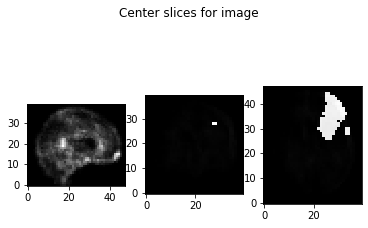

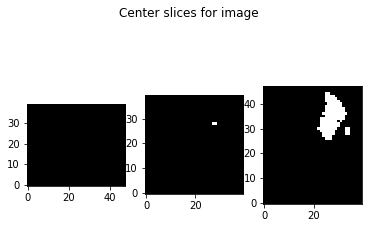

<module 'matplotlib.pyplot' from '/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [38]:
display(probas_3D[0, ...,1])
display(predicted_3D[0])

## Model (Features + Classifier) Evaluation 

In [39]:
from analysis_tools.metrics.plot_ROC import plot_roc
from analysis_tools.metrics.metrics import roc_auc, dice

In [40]:
dice_score = dice(predicted.flatten(), y_test.flatten())
roc_auc_score, roc_curve_details = roc_auc(y_test, predicted)

print('Dice:', dice_score)
print('ROC AUC:', roc_auc_score)

Dice: 1.0
ROC AUC: 1.0


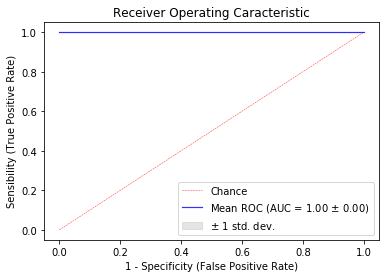

In [41]:
fpr, tpr, roc_thresholds = roc_curve_details
plot_roc([tpr], [fpr])

## Model feature analysis

#### Model confusion matrix

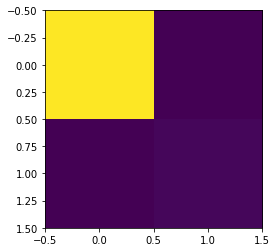

In [42]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, predicted)
plt.imshow(confusion)
plt.show()

#### Feature correalation 

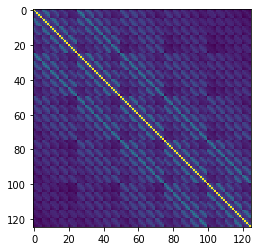

In [43]:
import numpy as np 

correlation = np.abs(np.corrcoef(X_train.T))
plt.imshow(correlation)
plt.show()
